# Lecture 17: Generative adversarial networks implementation

In this lecture, we are going to implement a version of generative adversarial training.



## Prepare the codebase

To get started, please clone a version of needle repo from the github. You should be able to use the need repo after finishng HW2

## Components of a generative advesarial network

There are two main components in a generative adversarial network
- A generator $G$ that takes a random vector $z$ and maps it to a generated(fake) data $G(z)$.
- A discriminator that attempts to tell the difference between the real dataset and the fake one.



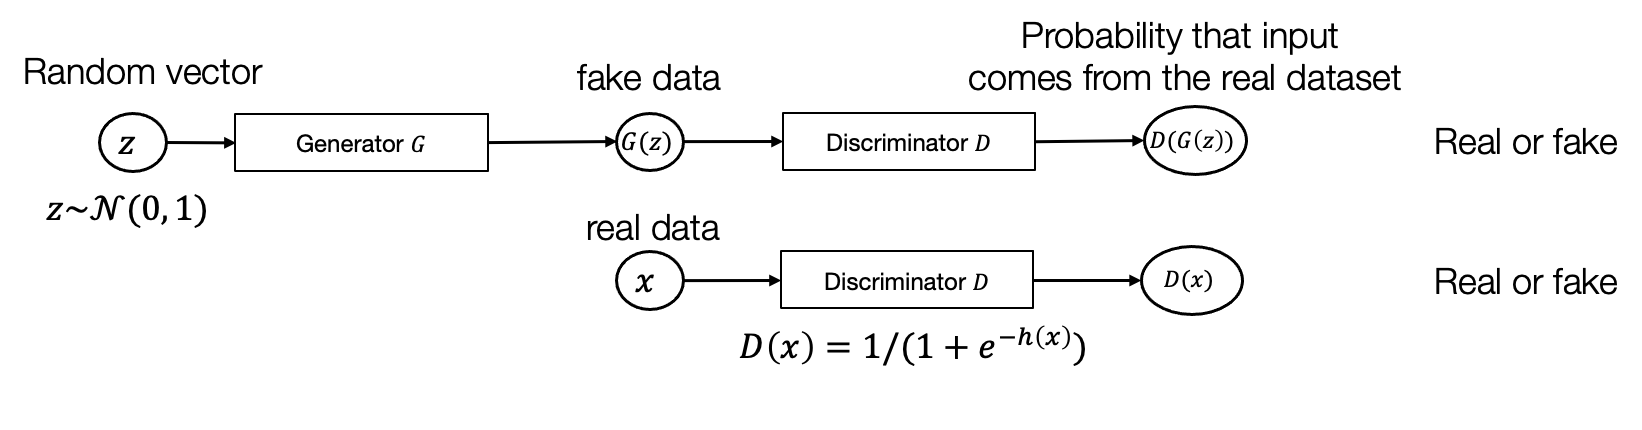

In [1]:
import sys
sys.path.append("../hw2/python/")

In [2]:
import needle as ndl
import numpy as np
from needle import nn
from matplotlib import pyplot as plt

In [3]:
%load_ext lab_black

### Parpare the training dataset

For demonstration purpose, we create our "real" dataset as a two dimensional gaussian distribution. 

\begin{equation} 
X \sim \mathcal{N}(\mu, \Sigma), \Sigma = A^T A 
\end{equation}

In [4]:
A = np.array([[1, 2], [-0.2, 0.5]])
mu = np.array([2, 1])

# total number of sample data to generated
num_sample = 3200

# This will make the data have mean of mu and variance of ATA
data = np.random.normal(0, 1, (num_sample, 2)) @ A + mu

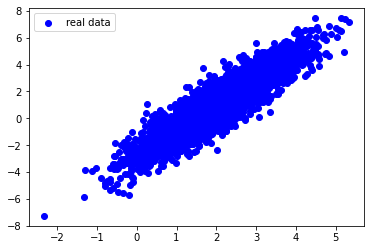

In [5]:
plt.scatter(data[:, 0], data[:, 1], color="blue", label="real data")
plt.legend()

Our goal is to create a generator that can generate a distribution that matches this distribution.

### Generator network $G$

Now we are ready to build our generator network G, to keep things simple, we make generator an one layer linear neural network.

In [6]:
model_G = nn.Sequential(nn.Linear(2, 2))

In [7]:
def sample_G(model_G, num_samples):
    Z = ndl.Tensor(np.random.normal(0, 1, (num_samples, 2)))
    fake_X = model_G(Z)
    return fake_X.numpy()

In [8]:
fake_data_init = sample_G(model_G, num_sample)

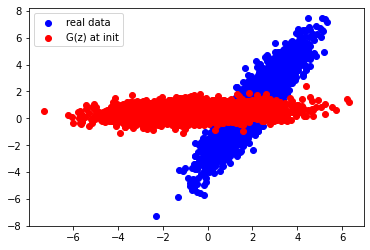

In [9]:
plt.scatter(data[:, 0], data[:, 1], color="blue", label="real data")
plt.scatter(
    fake_data_init[:, 0], fake_data_init[:, 1], color="red", label="G(z) at init"
)
plt.legend()

At the initialization phase, we just randomly initialized the weight of $G$, as a result, it certainly does not match the training data. Our goal is to setup a generative adveserial training to get it to close to the training data.

### Discriminator $D$

Now let us build a discriminator network $D$ that classifies the real data from the fake one. Here we use a three layer neural network. Additionally, we make use of the Softmax loss to measure the classification likelihood. Because we are only classifying two classes. Softmax function becomes the sigmoid function for prediction.

\begin{equation}
    \frac{\exp(x)} {\exp(x) +\exp(y)} =\frac{1}{1 + exp(y-x)} 
\end{equation}

We simply reuse SoftmaxLoss here since this is readily available in our current set of homework iterations. Most implementation will use a binary classification closs instead (BCELoss).

In [10]:
model_D = nn.Sequential(
    nn.Linear(2, 20), nn.ReLU(), nn.Linear(20, 10), nn.ReLU(), nn.Linear(10, 2)
)
loss_D = nn.SoftmaxLoss()

## Generative advesarial training

A Generative adversarial training process iteratively update the generator $G$ and discriminator $D$ to play a "minimax" game.

\begin{equation}
    \min_D\max_G\{-E_{x\sim Data} \log D(x) - E_{z\sim Noise} \log(1- D(G(z))\}
\end{equation}

Note that however, in practice, the $G$ update step usually use an alternative objective function.

\begin{equation}
    \min_G \{-E_{z\sim{Noise}} \log(D(G(z))\}
\end{equation}


### Generator update

Now we are ready to setup the generator update. In the generator update step, we need to optimize the following goal:

\begin{equation}
    \min_G \{-E_{z\sim{Noise}} \log(D(G(z))\}
\end{equation}

Let us first setup an optimizer for G's parameters.


In [11]:
opt_G = ndl.optim.Adam(model_G.parameters(), lr=0.01)


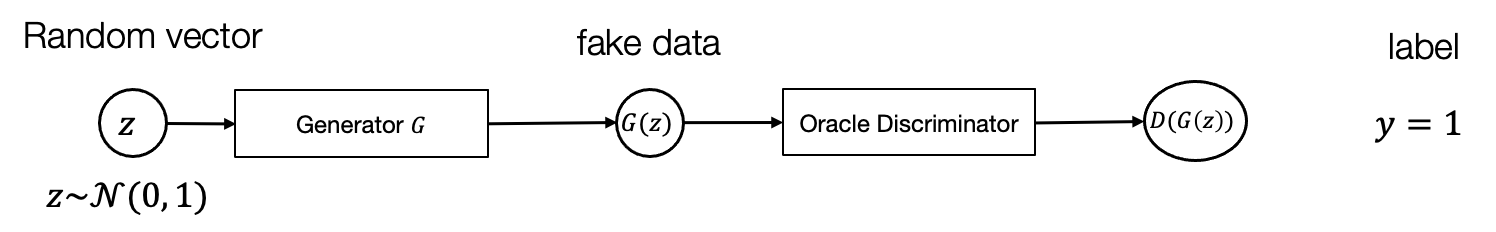

To optimize the above loss function, we just need to generate a fake data $G(z)$, send it through the discriminator $D$ and compute the negative log-likelihood that the fake dataset is categorized as real. In another word, we will feed in $y= 1$ as label here.


In [12]:
def update_G(Z, model_G, model_D, loss_D, opt_G):
    fake_X = model_G(Z)
    fake_Y = model_D(fake_X)
    batch_size = Z.shape[0]
    ones = ndl.init.ones(batch_size, dtype="int32")
    loss = loss_D(fake_Y, ones)
    loss.backward()
    opt_G.step()

### Discriminator update

Now, let us also setup the discriminator update step. The discriminator step optimizes the following objective:

\begin{equation}
    \min_D\{-E_{x\sim Data} \log D(x) - E_{z\sim Noise} \log(1- D(G(z))\}
\end{equation}

Let us first setup an optimizer to learn $D$'s parameters.

In [13]:
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)

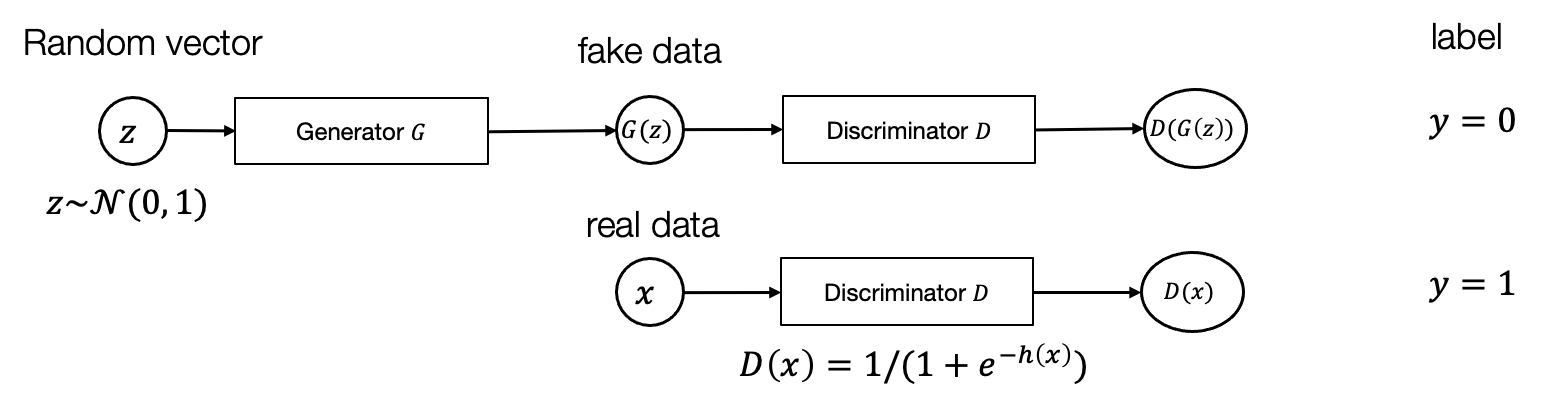

The discriminator loss is also a normal classification loss, by labeling the generated data as $y=0$(fake) and real data as $y=1$(real). Importantly, we also do not need to propagate gradient back to the generator in discriminator update, so we will use the detach function to stop the gradient propagation.


In [14]:
def update_D(X, Z, model_G, model_D, loss_D, opt_D):
    # detach to avoid the gradient to propagate to the
    # generator weights
    fake_X = model_G(Z).detach()
    fake_Y = model_D(fake_X)
    real_Y = model_D(X)
    assert X.shape[0] == Z.shape[0]
    batch_size = X.shape[0]
    ones = ndl.init.ones(batch_size, dtype="int32")
    zeros = ndl.init.zeros(batch_size, dtype="int32")
    loss = loss_D(real_Y, ones) + loss_D(fake_Y, zeros)
    loss.backward()
    opt_D.step()

## Putting it together

Now we can put it together, to summarize, the generative adverserial training cycles through the following steps:
- The discriminator update step
- Generator update step

In [35]:
A = np.array([[1, 2], [-0.2, 0.5]])
mu = np.array([2, 1])

# total number of sample data to generated
num_sample = 3200

# This will make the data have mean of mu and variance of ATA
data = np.random.normal(0, 1, (num_sample, 2)) @ A + mu

In [36]:
def sample_G(model_G, num_samples):
    Z = ndl.Tensor(np.random.normal(0, 1, (num_sample, 2)))
    return model_G(Z).numpy()

In [37]:
model_G = nn.Sequential(nn.Linear(2, 2))
model_D = nn.Sequential(
    nn.Linear(2, 20), nn.ReLU(), nn.Linear(20, 10), nn.ReLU(), nn.Linear(10, 2)
)

opt_G = ndl.optim.Adam(model_G.parameters(), lr=0.01)
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)

loss_D = nn.SoftmaxLoss()

In [38]:
def update_G(Z, model_G, model_D, loss_D, opt_G):
    # opt_G.reset_grad()
    fake_X = model_G(Z)
    fake_Y = model_D(fake_X)
    ones = ndl.init.ones(Z.shape[0], dtype="int32")
    loss = loss_D(fake_Y, ones)
    loss.backward()
    opt_G.step()

In [39]:
def update_D(X, Z, model_D, model_G, loss_D, opt_D):
    fake_X = model_G(Z).detach()
    # opt_D.reset_grad()
    fake_Y = model_D(fake_X)
    real_Y = model_D(X)
    ones = ndl.init.ones(X.shape[0], dtype="int32")
    zeros = ndl.init.zeros(X.shape[0], dtype="int32")
    loss = loss_D(fake_Y, zeros) + loss_D(real_Y, ones)
    loss.backward()
    opt_D.step()

In [42]:
def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        for begin_batch in range(0, data.shape[0], batch_size):
            X = ndl.Tensor(data[begin_batch : begin_batch + batch_size, :])
            Z = ndl.Tensor(np.random.normal(0, 1, (batch_size, 2)))
            update_D(X, Z, model_D, model_G, loss_D, opt_D)
            update_G(Z, model_G, model_D, loss_D, opt_G)

In [43]:
train_gan(data, 32, 10)

We can plot the generated data of the trained generator after a number of iterations. As we can see, the generated dataset $G(z)$ after get closer to the real data after training.

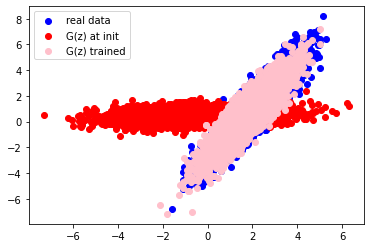

In [44]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:, 0], data[:, 1], color="blue", label="real data")
plt.scatter(
    fake_data_init[:, 0], fake_data_init[:, 1], color="red", label="G(z) at init"
)
plt.scatter(
    fake_data_trained[:, 0], fake_data_trained[:, 1], color="pink", label="G(z) trained"
)

plt.legend()

### Inspect the trained generator

We can compare the weight/bias of trained generator $G$ to the parameters we use to genrate the dataset. Importantly, we need to compare the covariance $\Sigma= A^T A$ here instead of the transformation matrix.

In [45]:
gA, gmu = model_G.parameters()

In [46]:
A.T @ A

array([[1.04, 1.9 ],
       [1.9 , 4.25]])

In [47]:
gA = gA.numpy()
gA.T @ gA

array([[0.9745823, 1.715979 ],
       [1.715979 , 3.742097 ]], dtype=float32)

In [48]:
A

array([[ 1. ,  2. ],
       [-0.2,  0.5]])

In [49]:
gA

array([[ 0.49248052,  1.6028962 ],
       [-0.8555964 , -1.0829684 ]], dtype=float32)

It is expected that A and gA to be very different because there are multiple matrices A that correspond to covariance matrix $A^TA$

We can also compare the mean

In [50]:
gmu, mu

(needle.Tensor([[1.7340626 0.4549384]]), array([2, 1]))

## Modularizing GAN "Loss"

We can modularize GAN step as in a similar way as loss function. The following codeblock shows one way to do so.

In [51]:
class GANLoss:
    def __init__(self, model_D, opt_D):
        self.model_D = model_D
        self.opt_D = opt_D
        self.loss_D = nn.SoftmaxLoss()

    def _update_D(self, real_X, fake_X):
        real_Y = self.model_D(real_X)
        fake_Y = self.model_D(fake_X.detach())
        batch_size = real_X.shape[0]
        ones = ndl.init.ones(batch_size, dtype="int32")
        zeros = ndl.init.zeros(batch_size, dtype="int32")
        loss = self.loss_D(real_Y, ones) + self.loss_D(fake_Y, zeros)
        loss.backward()
        self.opt_D.step()

    def forward(self, fake_X, real_X):
        self._update_D(real_X, fake_X)
        fake_Y = self.model_D(fake_X)
        batch_size = real_X.shape[0]
        ones = ndl.init.ones(batch_size, dtype="int32")
        loss = self.loss_D(fake_Y, ones)
        return loss

In [54]:
model_G = nn.Sequential(nn.Linear(2, 2))
opt_G = ndl.optim.Adam(model_G.parameters(), lr=0.01)

model_D = nn.Sequential(
    nn.Linear(2, 20), nn.ReLU(), nn.Linear(20, 10), nn.ReLU(), nn.Linear(10, 2)
)
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)
gan_loss = GANLoss(model_D, opt_D)

In [55]:
def train_gan(data, batch_size, num_epochs):
    for epoch in range(num_epochs):
        for begin in range(0, data.shape[0], batch_size):
            X = data[begin : begin + batch_size, :]
            # Sample from normal distribution
            Z = np.random.normal(0, 1, (batch_size, 2))
            X = ndl.Tensor(X)
            Z = ndl.Tensor(Z)
            fake_X = model_G(Z)
            loss = gan_loss.forward(fake_X, X)
            loss.backward()
            opt_G.step()

In [56]:
train_gan(data, 32, 10)

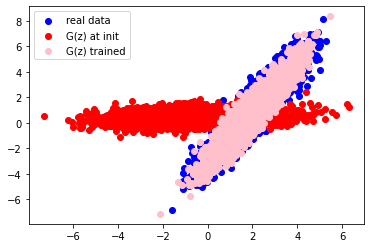

In [57]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:, 0], data[:, 1], color="blue", label="real data")
plt.scatter(
    fake_data_init[:, 0], fake_data_init[:, 1], color="red", label="G(z) at init"
)
plt.scatter(
    fake_data_trained[:, 0], fake_data_trained[:, 1], color="pink", label="G(z) trained"
)

plt.legend()